# **1. Import thư viện**

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

# **2. Chuẩn bị dữ liệu**

In [3]:
# Tải dữ liệu
df = pd.read_csv('ECommerce_Dataset_cleaned_model.csv')

In [4]:
df.head()

,Churn,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,DaySinceLastOrder,CashbackAmount,DevicePerTenure
0,1,3,6,3,3,Laptop & Accessory,2,Single,9,1,11,1,5,160,0.75
1,1,1,8,3,4,Mobile Phone,3,Single,7,1,15,0,0,121,4.00
2,1,1,30,2,4,Mobile Phone,3,Single,6,1,14,0,3,120,4.00
3,1,3,15,2,4,Laptop & Accessory,5,Single,8,0,23,0,3,134,4.00
4,1,1,12,3,3,Mobile Phone,5,Single,3,0,11,1,3,130,3.00


In [5]:
# Xác định biến đầu vào và mục tiêu
target = 'Churn'

X = df.drop(columns=[target])
y = df[target]

In [6]:
# Xác định cột định lượng (numeric) và định tính (categorical)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# **3. Tạo Pipeline (Tiền xử lý + Mô hình)**

In [7]:
# ColumnTransformer: One-Hot Encoding + Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

In [8]:
# Xây dựng model
model = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    alpha=0.01,
    max_iter=300,
    random_state=42
)

In [9]:
# Xây dựng Pipeline
clf = Pipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', model)
])

In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# **4. Cross validation (10-fold)**

In [11]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict')
y_proba_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

In [12]:
roc_auc_cv = roc_auc_score(y_train, y_proba_cv)
print(f"CV ROC-AUC: {roc_auc_cv:.4f}")

CV ROC-AUC: 0.9644


In [13]:
print("\nClassification Report (Cross-Validation on Train):")
print(classification_report(y_train, y_pred_cv))


Classification Report (Cross-Validation on Train):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3746
           1       0.81      0.81      0.81       758

    accuracy                           0.94      4504
   macro avg       0.88      0.89      0.88      4504
weighted avg       0.94      0.94      0.94      4504



# **5. Huấn luyện & dự đoán**

In [14]:
# Train model
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CityTier',
                                                   'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount',
                                                   'DevicePerTenure']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 MLPClassifier(alpha=0.01, hidden_layer_sizes=(32, 16),
                               max_iter=300, random_state=42))])

In [15]:
# Dự đoán
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

# **6. Đánh giá mô hình**

In [16]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       936
           1       0.82      0.94      0.87       190

    accuracy                           0.95      1126
   macro avg       0.90      0.95      0.92      1126
weighted avg       0.96      0.95      0.96      1126



**Nhận xét:**

- Mô hình MLP đạt **accuracy 95%** và **F1-score trung bình 0.92**, cho thấy hiệu quả phân loại tổng thể tốt.

- Lớp 0: **precision rất cao (0.99)** và **recall 0.96**, hầu hết dự đoán lớp này chính xác, chỉ một phần nhỏ bị nhầm sang churn. **F1-score 0.97** cho thấy sự cân bằng tốt giữa precision và recall.

- Lớp 1: **recall đạt 0.94** và **F1-score 0.87**, cho thấy mô hình phát hiện tốt phần lớn khách hàng churn, tuy nhiên **precision 0.82** phản ánh vẫn còn một tỷ lệ dự đoán nhầm từ lớp 0 sang 1.

- Nhìn chung, mô hình xử lý tốt dữ liệu mất cân bằng, thể hiện sự cân bằng giữa việc phát hiện khách hàng churn (recall cao) và hạn chế dự đoán nhầm (precision hợp lý).


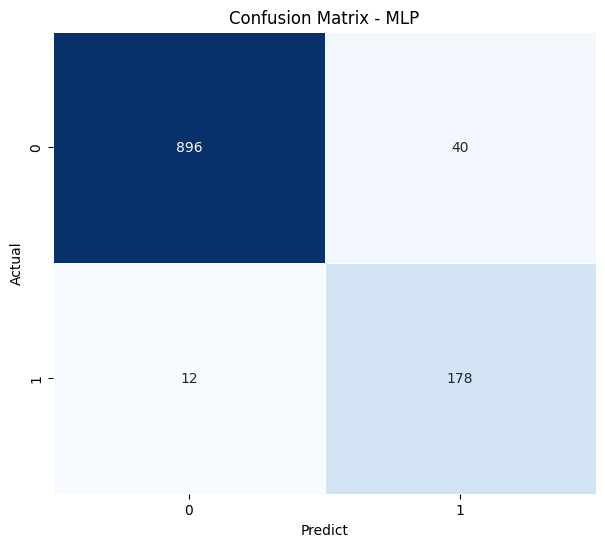

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=False, linewidths=0.5)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MLP')
plt.show()

**Nhận xét:**

- Ma trận nhầm lẫn cho thấy mô hình MLP đạt hiệu suất phân loại tốt, với **tổng số lỗi là 52 trên 1126 mẫu**.

- Dự đoán đúng:
  - Xác định chính xác **178 khách hàng sẽ rời bỏ**
  - Xác định chính xác **896 khách hàng trung thành**
- Dự đoán sai:
  - Bỏ lỡ 12 khách hàng thực sự đã rời bỏ
  - Dự đoán nhầm 40 khách hàng trung thành là sẽ rời bỏ

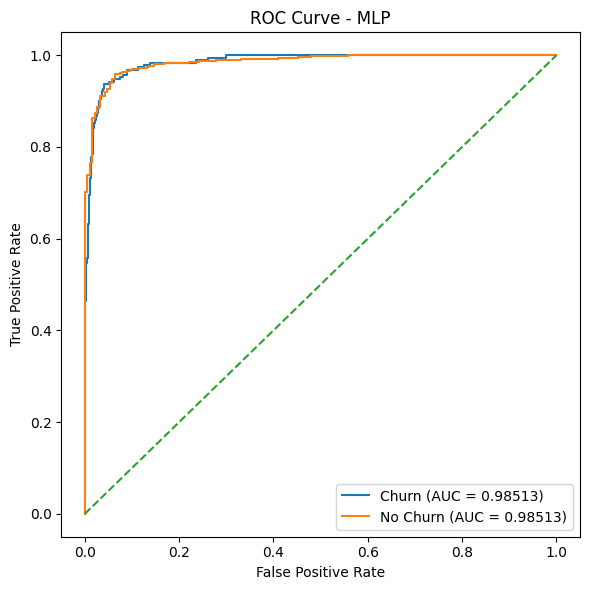

In [18]:
# vẽ ROC Curve

# Lớp churn = 1
fpr_1, tpr_1, _ = roc_curve(y_test, y_proba[:, 1])
auc_1 = auc(fpr_1, tpr_1)

# Lớp churn = 0
fpr_0, tpr_0, _ = roc_curve(1 - y_test, y_proba[:, 0])
auc_0 = auc(fpr_0, tpr_0)

plt.figure(figsize=(6, 6))
plt.plot(fpr_1, tpr_1, label=f'Churn (AUC = {auc_1:.5f})')
plt.plot(fpr_0, tpr_0, label=f'No Churn (AUC = {auc_0:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP')
plt.legend()
plt.tight_layout()
plt.show()

**Nhận xét:**

- **AUC = 0.98513**: Mô hình có khả năng phân biệt xuất sắc giữa khách hàng Churn và không Churn.
- Đường cong ôm sát góc trên bên trái cho thấy mô hình có thể đạt được tỷ lệ phát hiện đúng cao trong khi vẫn giữ tỷ lệ báo động giả ở mức rất thấp.